In [1]:
"""
June 2022
IFREMER LOPS
Algorithm Technical Baseline Document (ATBD) for cross/co spectra computation with xsarsea python library.
"""

'\nJune 2022\nIFREMER LOPS\nAlgorithm Technical Baseline Document (ATBD) for cross/co spectra computation with xsarsea python library.\n'

 In this ATBD (standing for Algorithm Theoritical Baseline Document) you will find the description of the different processing steps implemented in 
xsarsea python library. And links to the API and usage documentation to have a look at the implementation.

# How to compute cross spectra from Sentinel-1 SAR WV SLC (Single Look Complex) acquisition?

## dataflow

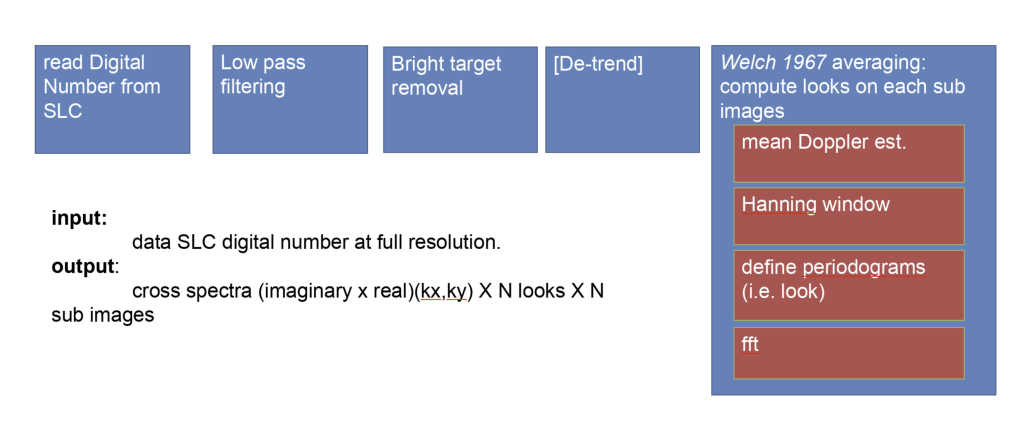

In [1]:
from matplotlib.pyplot import imread,imshow
import matplotlib.pyplot as plt
im = imread('./images/WV_SLC_xpsec_workflow.png')
plt.figure(figsize=(10,16),dpi=130)
ax=plt.gca()
imshow(im)
ax.axis('off')
plt.show()

## tasks description

### low pass filtering

 - **input**: Digital Number at highest resolution: matric of complex numbers
 - **output**: image modulation (normalized), with complex numbers
 - **purpose**: low pass filtering allows to keep only modulation in the image, so any gain apply in the SAR imaging mecanism or during compression step is  harmless for the final estimation of cross spectrum amplitudes.
 
 $ \Huge im_{modulation} = \frac{DN}{\sqrt{im_{lowpass}}}$

In [1]:
import logging
from importlib import reload
reload(logging)
logging.basicConfig(level=logging.INFO)
import xsarsea.from_tiff_WV_to_modulation as tiff2modulation
tiff_full_path = '/home/datawork-cersat-public/project/mpc-sentinel1/data/esa/sentinel-1a/L1/WV/S1A_WV_SLC__1S/2019/278/S1A_WV_SLC__1SSV_20191005T163939_20191005T171407_029326_035559_2461.SAFE/measurement/s1a-wv1-slc-vv-20191005t165023-20191005t165026-029326-035559-045.tiff'
DN_vv_slc_meters_modulation = tiff2modulation.from_tiff_to_modulation(tiff_full_path,polarization='VV')
DN_vv_slc_meters_modulation

INFO:xsar.utils:BlockingActorProxy: Transparent proxy for Sentinel1Meta


xsarsea /home1/datahome/agrouaze/sources/git/xsarsea/src/xsarsea/__init__.py


<xarray.Dataset>
Dimensions:               (pol: 1, line: 4930, sample: 5663)
Coordinates:
  * pol                   (pol) object 'VV'
  * line                  (line) int64 0 1 2 3 4 5 ... 4925 4926 4927 4928 4929
  * sample                (sample) int64 0 1 2 3 4 ... 5658 5659 5660 5661 5662
    spatial_ref           int64 0
Data variables: (12/15)
    digital_number        (pol, line, sample) complex64 dask.array<chunksize=(1, 4930, 5000), meta=np.ndarray>
    time                  (line) timedelta64[ns] 18174 days 16:50:23.72094489...
    sampleSpacing         float64 1.498
    lineSpacing           float64 4.139
    ground_heading        (line, sample) float32 dask.array<chunksize=(4930, 5000), meta=np.ndarray>
    land_mask             (line, sample) int8 dask.array<chunksize=(4930, 5000), meta=np.ndarray>
    ...                    ...
    incidence             (line, sample) float64 dask.array<chunksize=(4930, 5000), meta=np.ndarray>
    elevation             (line, sample) flo

INFO:root:lowpass_sigma = [181.18778012 500.80930784]
INFO:root:lp (5760, 3841)
INFO:root:outslice (slice(725, 5655, None), slice(2003, 7666, None))
INFO:root:fftshape [5760, 7680]
INFO:root:axes range(-2, 0)
INFO:root:tmp : (5760, 7680)
INFO:root:lowpass (4930, 5663) mean: 705479.0874610025


<xarray.DataArray 'digital_number' (azimuth: 4930, range: 5663)>
dask.array<truediv, shape=(4930, 5663), dtype=complex128, chunksize=(4930, 5000), chunktype=numpy.ndarray>
Coordinates:
  * azimuth  (azimuth) float64 0.0 4.139 8.279 ... 2.039e+04 2.04e+04 2.04e+04
  * range    (range) float64 0.0 3.642 7.285 ... 2.062e+04 2.062e+04 2.062e+04
Attributes:
    comment:  denoised digital number, read at full resolution
    history:  digital_number: measurement/s1a-wv1-slc-vv-20191005t165023-2019...

### cross spectrum computation

In [2]:
from xsarsea.cross_spectra_core import compute_SAR_cross_spectrum2
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import time
t0 = time.time()
nperseg = {'range': 512, 'azimuth': 512}
noverlap = {'range': 256, 'azimuth': 256}
N_look = 3
look_width = 0.2
look_overlap = 0.1
allspecs = compute_SAR_cross_spectrum2(DN_vv_slc_meters_modulation, N_look=N_look, look_width=look_width, look_overlap=look_overlap, look_window=None,
                                range_spacing=None, welsh_window='hanning', nperseg=nperseg,
                                noverlap=noverlap, spacing_tol=1e-3)
logging.info('time to get all X-spectra on WV with N_look:%s look_width %s look_overlap %s nperseg %sx%s  noverlap %sx%s : %1.2f seconds',
             N_look,look_width,look_overlap,nperseg['range'],nperseg['azimuth'],noverlap['range'],noverlap['azimuth'],time.time()-t0)

INFO:root:time to get all X-spectra on WV with N_look:3 look_width 0.2 look_overlap 0.1 nperseg 512x512  noverlap 256x256 : 367.09 seconds


In [4]:
allspecs

<xarray.Dataset>
Dimensions:              (0tau: 1134, ky: 102, kx: 512, 1tau: 756, 2tau: 378)
Coordinates:
  * kx                   (kx) float64 -0.8625 -0.8591 -0.8557 ... 0.8557 0.8591
  * ky                   (ky) float64 -0.1518 -0.1488 -0.1458 ... 0.1458 0.1488
Dimensions without coordinates: 0tau, 1tau, 2tau
Data variables:
    cross-spectrum_0tau  (0tau, ky, kx) complex128 (77042710639211.02+0j) ......
    cross-spectrum_1tau  (1tau, ky, kx) complex128 (-131983893901142.11+0.031...
    cross-spectrum_2tau  (2tau, ky, kx) complex128 (55639685078504.66-0.00185...

In [6]:
import numpy as np
how_manu_tau = '2'
XS=np.abs(allspecs['cross-spectrum_%stau'%how_manu_tau].mean(dim='%stau'%how_manu_tau).real)
print(np.isnan(XS).any().values)
XS

False


<xarray.DataArray 'cross-spectrum_2tau' (ky: 102, kx: 512)>
array([[4.12505012e+12, 1.46242733e+12, 1.72156455e+12, ...,
        1.07713834e+13, 1.72156455e+12, 1.46242733e+12],
       [2.28021449e+11, 1.24395115e+13, 1.25883831e+12, ...,
        8.97576039e+12, 3.29092445e+12, 7.10982229e+12],
       [7.55699377e+12, 9.30594695e+12, 8.91792329e+11, ...,
        1.93802192e+13, 2.01432727e+13, 5.09386354e+12],
       ...,
       [4.70022359e+12, 4.52055821e+12, 5.95608857e+12, ...,
        1.46300336e+12, 6.32741223e+12, 1.81061839e+12],
       [7.55699377e+12, 5.09386354e+12, 2.01432727e+13, ...,
        2.48050029e+12, 8.91792329e+11, 9.30594695e+12],
       [2.28021449e+11, 7.10982229e+12, 3.29092445e+12, ...,
        4.51873899e+12, 1.25883831e+12, 1.24395115e+13]])
Coordinates:
  * kx       (kx) float64 -0.8625 -0.8591 -0.8557 ... 0.8524 0.8557 0.8591
  * ky       (ky) float64 -0.1518 -0.1488 -0.1458 ... 0.1429 0.1458 0.1488

/home/datawork-cersat-public/cache/project/mpc-sentinel1/workspace/mamba/envs/xsar_oct22/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


cutt-off : 32950512522.02766 m


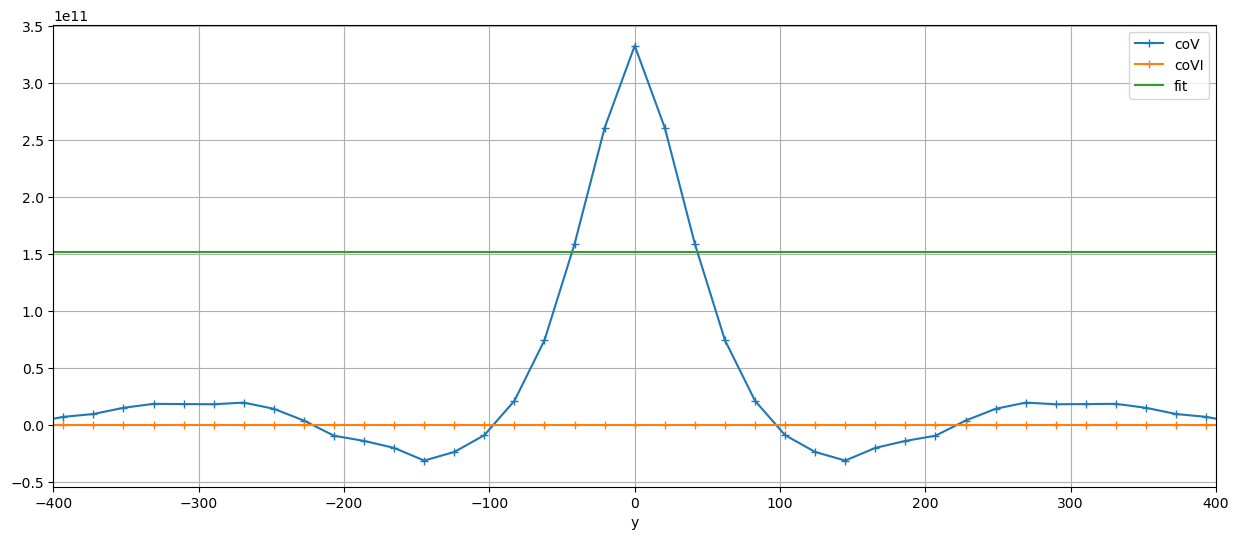

In [9]:
import xrft

coV = xrft.idft(XS, dim=('kx','ky'), shift=True) # 2D ifft on the cartesian co-spectrum
coV.data = np.fft.fftshift(coV.data)
coV = coV.assign_coords(freq_kx=2*np.pi*coV.freq_kx.data, freq_ky=2*np.pi*coV.freq_ky.data)
coV = coV.rename(freq_kx='x', freq_ky='y')
coVI = np.imag(coV).mean(dim='x')
coV = np.real(coV).mean(dim='x')


from matplotlib import pyplot as plt 
coVfit = coV.where(np.abs(coV.y)<100, drop=True) # I use only [-100 , 100] to do the fit. Can be a bit adjusted
from scipy.optimize import curve_fit
def fit_gauss(x,a,l):
    return a*np.exp(-(np.pi*x/l)**2) # expression of the fit in the ATBD
p,r=curve_fit(fit_gauss, coVfit.y,coVfit.data, p0=[450,227]) # Here is the actual fitting which works pretty well

plt.figure(figsize=(15,6))
coV.plot(marker='+',label='coV')
coVI.plot(marker='+',label='coVI')
plt.plot(coV.y, fit_gauss(coV.y,*p),label='fit')
plt.grid()
plt.legend()
plt.xlim([-400,400])
print('cutt-off : {} m'.format(p[1]))

cutt-off : 152.0514493565877 m


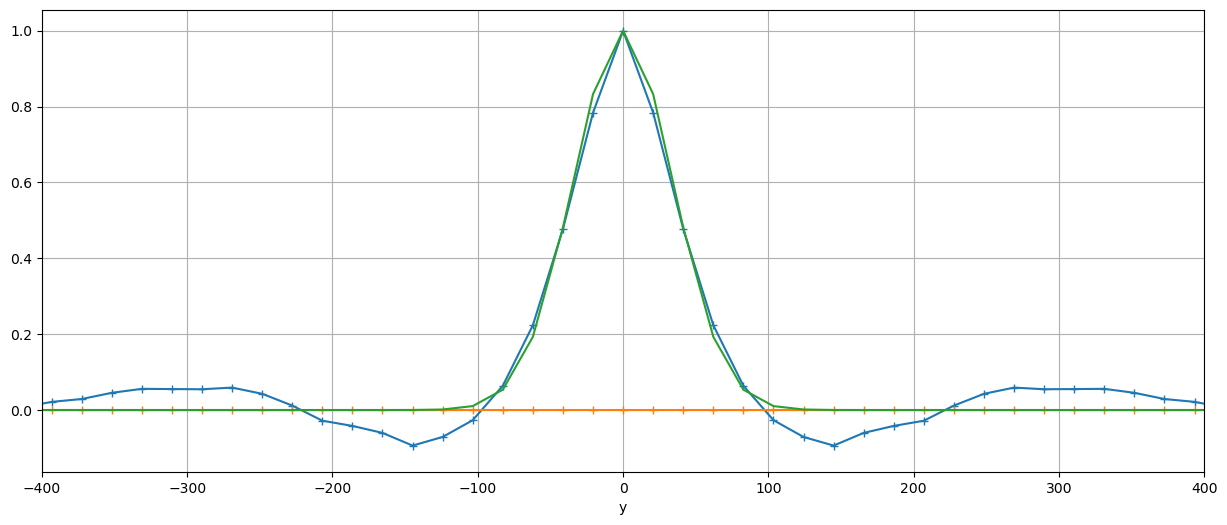

In [10]:
coV/=coV.max()

coVfit = coV.where(np.abs(coV.y)<200, drop=True) # I use only [-100 , 100] to do the fit. Can be a bit adjusted
from scipy.optimize import curve_fit
def fit_gauss(x,l):
    return np.exp(-(np.pi*x/l)**2) # expression of the fit in the ATBD
p,r=curve_fit(fit_gauss, coVfit.y,coVfit.data, p0=[200]) # Here is the actual fitting which works pretty well

plt.figure(figsize=(15,6))
coV.plot(marker='+')
coVI.plot(marker='+')
plt.plot(coV.y, fit_gauss(coV.y,*p))
plt.grid()
plt.xlim([-400,400])
print('cutt-off : {} m'.format(p[0]))

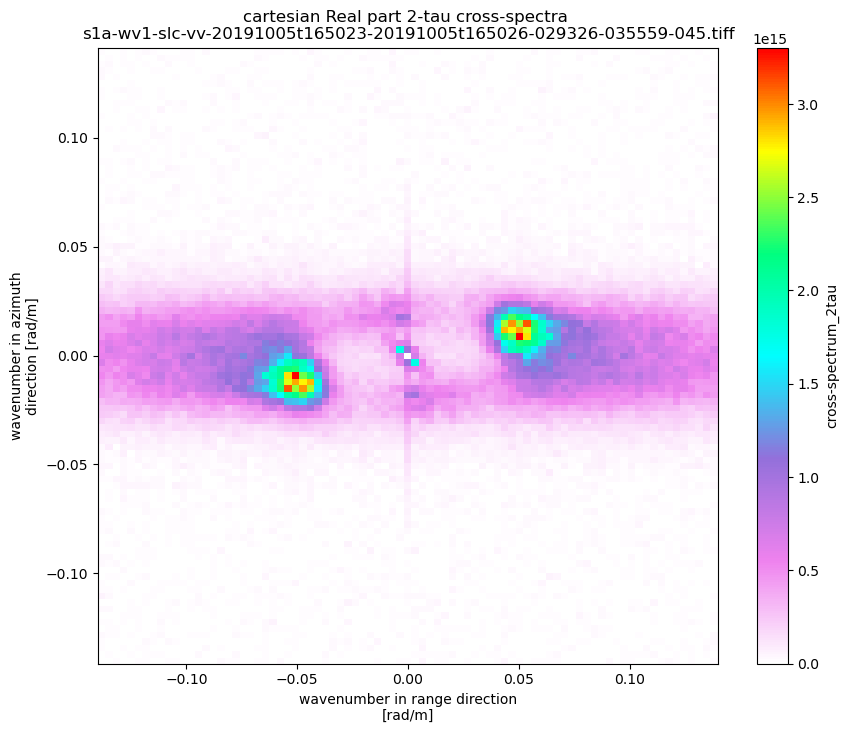

In [18]:
from matplotlib import colors as mcolors
import os
cmap = mcolors.LinearSegmentedColormap.from_list("", ["white","violet","mediumpurple","cyan","springgreen","yellow","red"])
how_manu_tau = 2
sp_re_cart=abs(allspecs['cross-spectrum_%stau'%how_manu_tau].mean(dim='%stau'%how_manu_tau).real)
sp_re_cart2 = sp_re_cart.where(np.logical_and(np.abs(sp_re_cart.kx)<=0.14, np.abs(sp_re_cart.ky)<=0.14), drop=True)
sp_re_cart2.plot(cmap=cmap,figsize=(10,8))
plt.title('cartesian Real part 2-tau cross-spectra \n'+os.path.basename(tiff_full_path))
plt.show()